In [2]:
import numpy as np # For mathematical calculation

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow import keras


In [1]:
plantVillage = './potato images'

In [3]:
# Hyperparameters
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 50

In [4]:
dataset = keras.preprocessing.image_dataset_from_directory(
    plantVillage,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
print(f"The length of the dataset is: {len(dataset)}")

The length of the dataset is: 68


---
The length of the dataset is 68 because we defined the batch size as 32. Therefore, the 2152 images present in the directory are divided into 67 full batches of 32 images each, and 1 batch containing 24 images.

In [6]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

---
The dataset comprises **three distinct categories** that are used to classify the images of potato plants. The classes are as follows:

**Potato___Early_blight:** This class represents images of potato plants affected by Early Blight, a common fungal disease caused by the pathogen Alternaria solani. Early Blight typically manifests as dark, concentric spots on the leaves, leading to significant crop damage if not managed properly.

**Potato___Late_blight:** This class includes images of potato plants showing symptoms of Late Blight, a devastating disease caused by the oomycete Phytophthora infestans. Late Blight is characterized by water-soaked lesions that rapidly spread, causing extensive damage to the foliage and tubers.

**Potato___healthy:**This class consists of images of healthy potato plants with no visible signs of disease. These images serve as a baseline to help differentiate between diseased and healthy plants, enabling the model to accurately detect and classify the presence of Early Blight and Late Blight.

In [7]:
for image_batch, label_batch in dataset.take(1): # This will take the first batch
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 2 1 0]


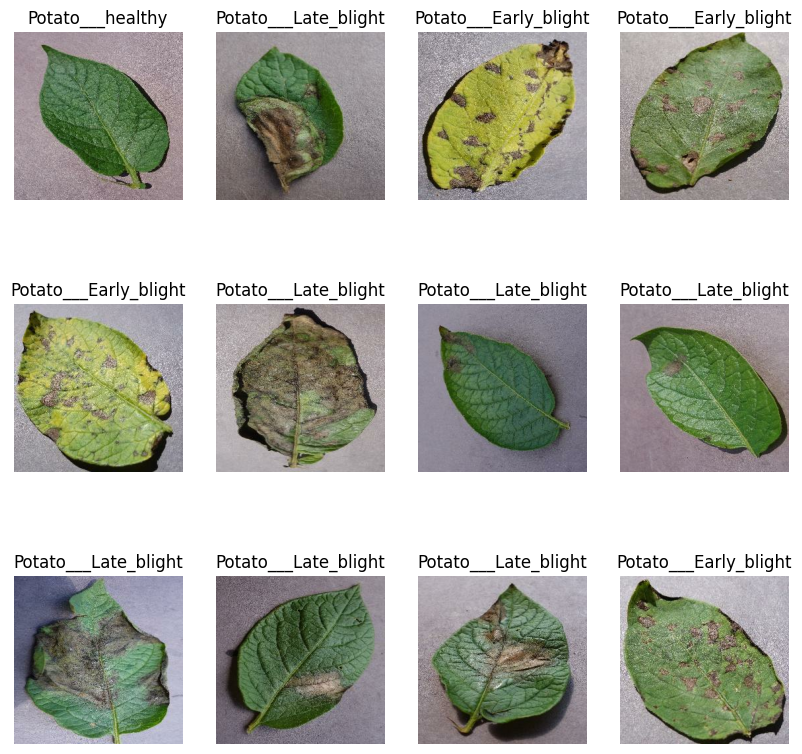

In [8]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4, i+1 )
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_name[label_batch[i]])
    plt.axis('off')

In [9]:
# Function to get train set, test set, and validation set

def get_dataset_partition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True,shuffle_size = 10000 ):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(val_ds)

6

In [13]:
len(test_ds)

8

In [14]:
# Optimizing Dataset Performance for Training, Validation, and Testing

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Preprocessing layers

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE , IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

In [18]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),

])
model.build(input_shape = input_shape)

c:\Users\ashar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics = ['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 641ms/step - accuracy: 0.4618 - loss: 0.9303 - val_accuracy: 0.4531 - val_loss: 0.8363
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 568ms/step - accuracy: 0.5303 - loss: 0.8599 - val_accuracy: 0.6719 - val_loss: 0.7304
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 576ms/step - accuracy: 0.7390 - loss: 0.6459 - val_accuracy: 0.7188 - val_loss: 0.7889
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 779ms/step - accuracy: 0.7943 - loss: 0.5017 - val_accuracy: 0.8229 - val_loss: 0.5218
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 894ms/step - accuracy: 0.8475 - loss: 0.3531 - val_accuracy: 0.9167 - val_loss: 0.2254
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 846ms/step - accuracy: 0.9191 - loss: 0.2535 - val_accuracy: 0.9010 - val_loss: 0.3090
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 737ms/step - accuracy: 0.9445 - loss: 0.1636 - val_accuracy: 0.8802 - val_loss: 0.2730
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 748ms/step - accuracy: 0.9394 - loss: 0.1722 - val_accu

In [23]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.9828 - loss: 0.0242


[0.02331426739692688, 0.984375]

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

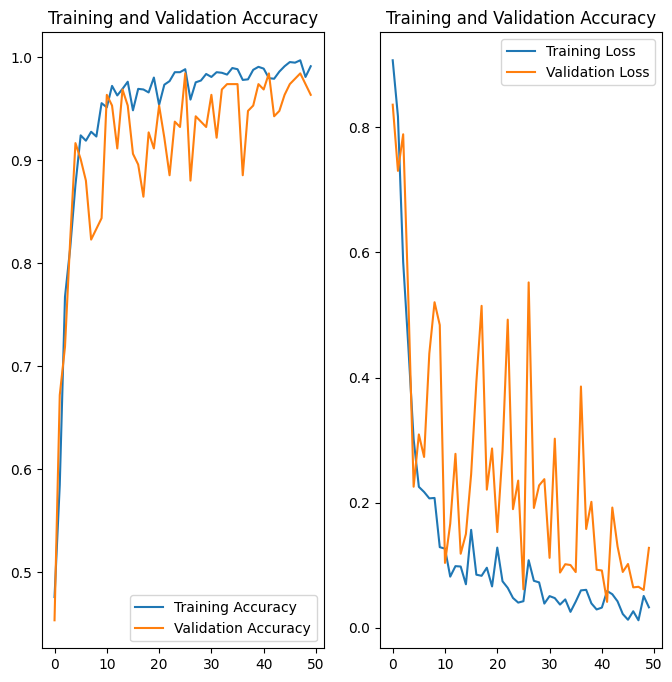

In [28]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
Predicted label: Potato___Late_blight


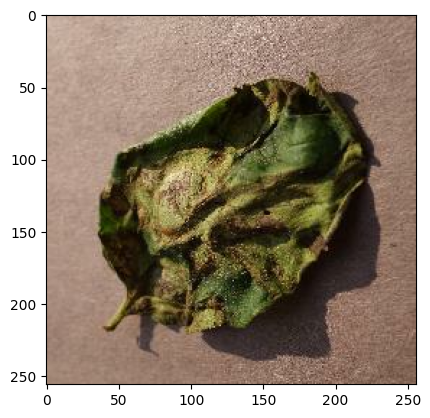

In [29]:
for image_batch, label_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0]

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label:', class_name[first_label])

  batch_prediction = model.predict(image_batch)
  print('Predicted label:', class_name[np.argmax(batch_prediction[0])])


In [30]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) # create a batch

  predictions = model.predict(img_array)

  predicted_class = class_name[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


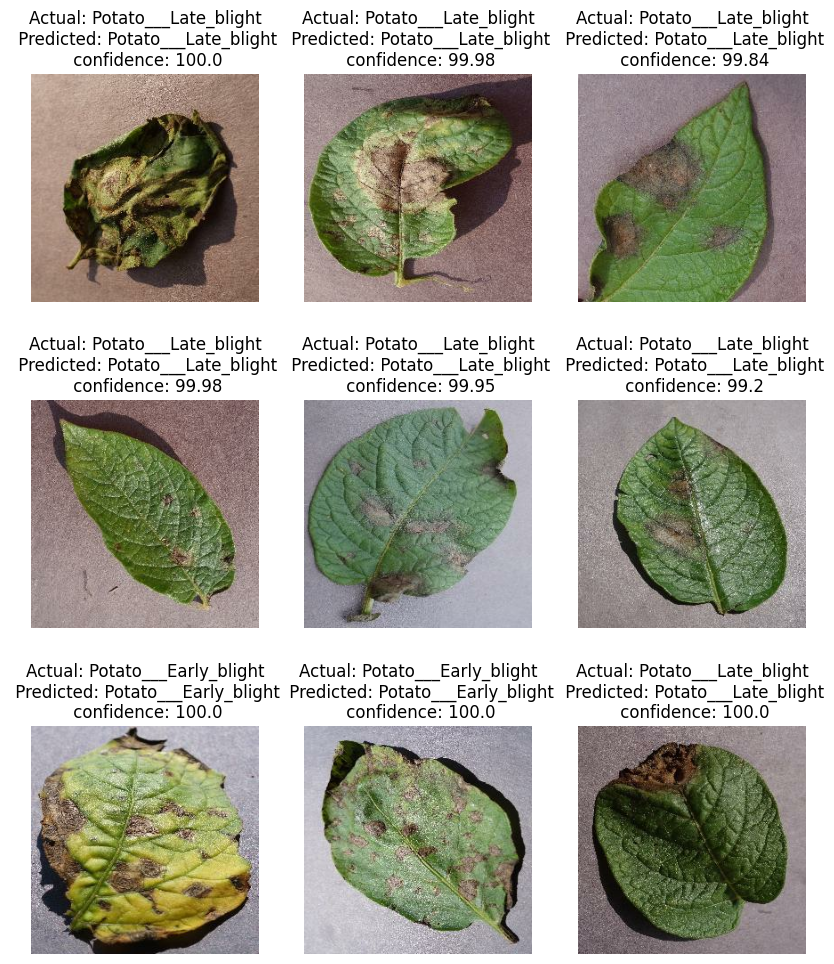

In [31]:
plt.figure(figsize = (10,12))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_name[labels[i]]
    plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n confidence: {confidence}")
    plt.axis('off')


In [48]:
import os
files = os.listdir("./models")

numeric_versions = []
for file in files:
    try:
        # Extract the numeric part from the filename
        version = int(file.split('.')[0])
        numeric_versions.append(version)
    except ValueError:
        # Ignore files that do not start with a number
        pass

# Determine the next model version
model_version = max(numeric_versions, default=0) + 1

# Save the model with the new version number
model.save(f"../models/{model_version}.keras")
